In [167]:
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np

In [168]:
bag = bagpy.bagreader('/home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/kf_circular_4_2024-04-20-01-02-39.bag')
bag.topic_table

[INFO]  Data folder /home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/kf_circular_4_2024-04-20-01-02-39 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/Imu,sensor_msgs/Imu,30326,100.140961
1,/SteeringAngle,std_msgs/Float64,30359,100.004864
2,/clock,rosgraph_msgs/Clock,30326,100.157700
3,/cmd_vel,std_msgs/Float64,30358,100.004864
4,/current_heading,std_msgs/Float64,29233,99.976259
5,/current_linear_velocity,geometry_msgs/Vector3,29233,99.966728
6,/odom,nav_msgs/Odometry,30326,100.136179
7,/path_planner/trajectory,std_msgs/Float32MultiArray,1,NaN
8,/rosout,rosgraph_msgs/Log,15,64035.175573
9,/rosout_agg,rosgraph_msgs/Log,1,NaN


In [169]:
# extract topics of interest
ground_truth_topic_data = pd.read_csv(bag.message_by_topic('/odom'))
heading_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_heading'))
velocity_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_linear_velocity'))

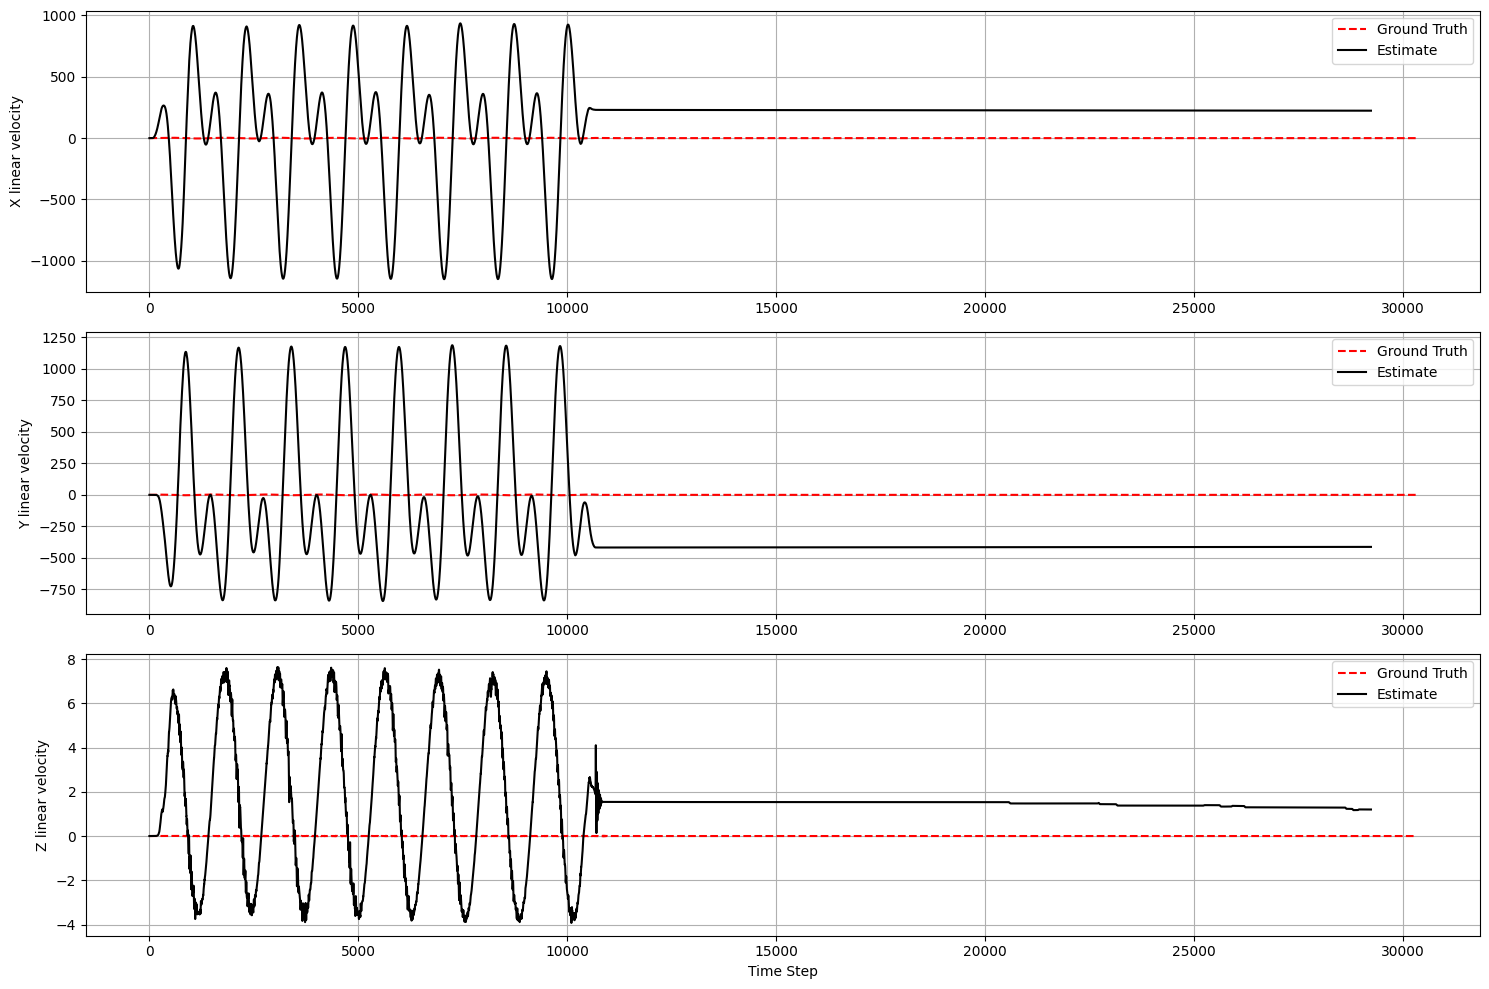

In [170]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_velocity = [ground_truth_topic_data['twist.twist.linear.x'], ground_truth_topic_data['twist.twist.linear.y'], ground_truth_topic_data['twist.twist.linear.z']]
estimated_velocity = [velocity_estimations_topic_data['x'], velocity_estimations_topic_data['y'], velocity_estimations_topic_data['z']]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(range(len(ground_truth_velocity[i])), ground_truth_velocity[i], label='Ground Truth', color='red', linestyle = '--')
    ax.plot(range(len(estimated_velocity[i])), estimated_velocity[i], label='Estimate', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} linear velocity')
    ax.legend()
    ax.grid()

plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

In [171]:
'''
    Plotting the ground truth heading compared to the estimated heading
'''
from tf.transformations import euler_from_quaternion

ground_truth_orientation = [ground_truth_topic_data['pose.pose.orientation.x'], ground_truth_topic_data['pose.pose.orientation.y'],ground_truth_topic_data['pose.pose.orientation.z'], ground_truth_topic_data['pose.pose.orientation.w']]
estimated_heading = heading_estimations_topic_data['data']

ground_truth_heading = np.zeros_like(ground_truth_orientation[1].values)

# Converting the orientation from quaternion to euler and extracting the yaw

for i in range(len(ground_truth_heading)):
    ground_truth_heading[i] = euler_from_quaternion((ground_truth_orientation[0][i], ground_truth_orientation[1][i], ground_truth_orientation[2][i], ground_truth_orientation[3][i]))[2]

estimated_heading = estimated_heading[:12500]
ground_truth_heading = ground_truth_heading[:12500]

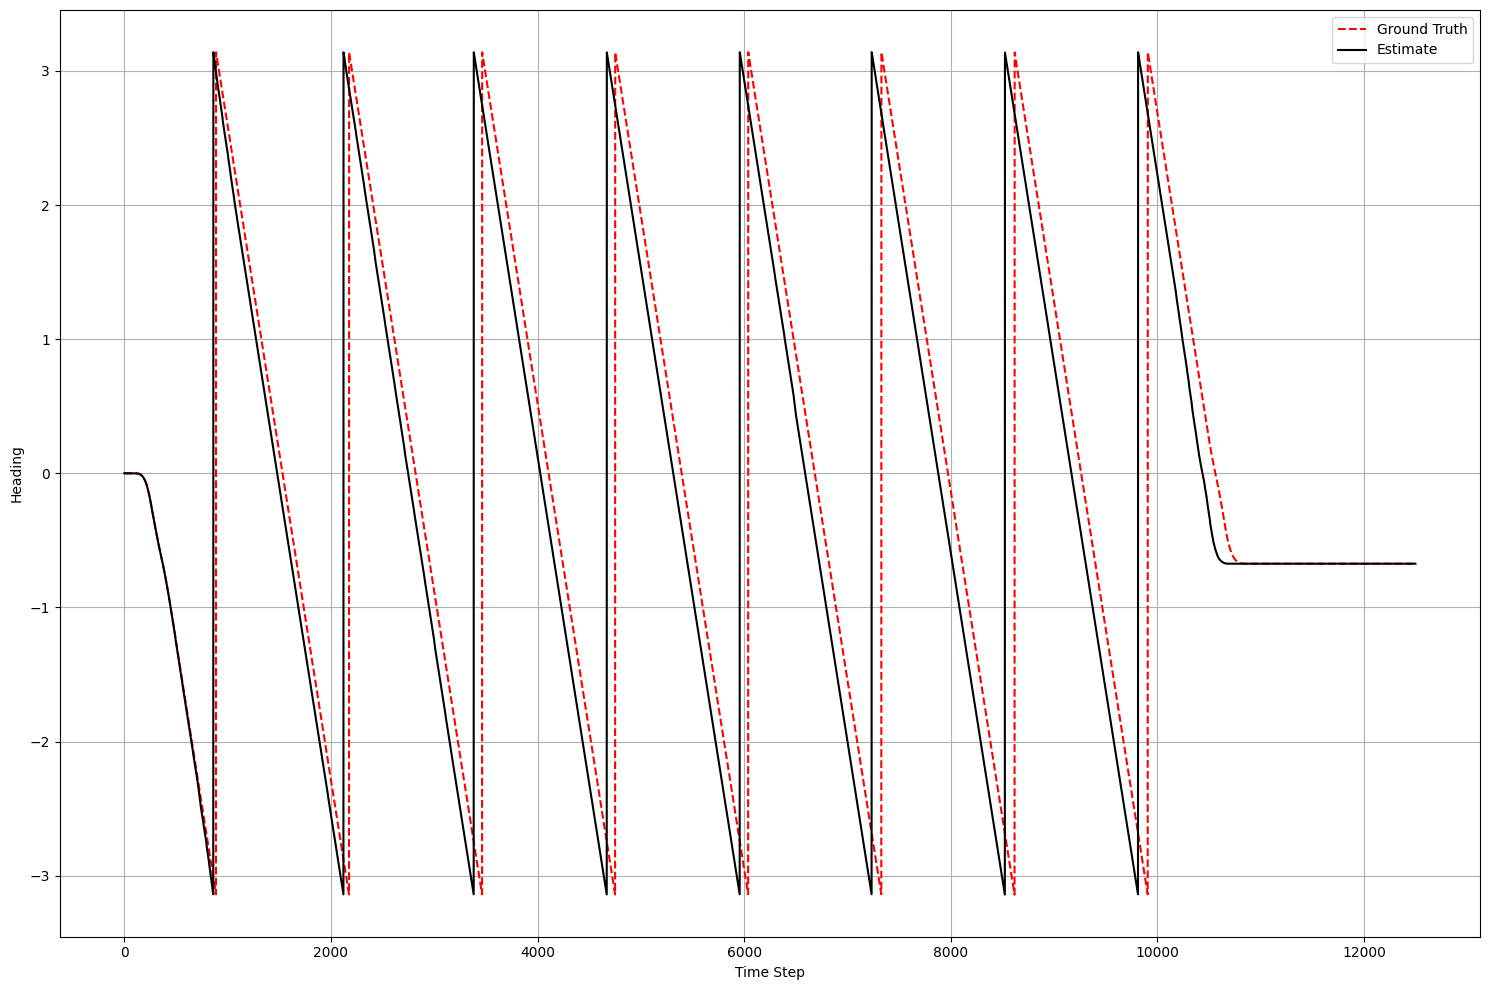

In [172]:

fig2, axes2 = plt.subplots(1, 1, figsize=(15, 10))
axes2.plot(range(len(ground_truth_heading)), ground_truth_heading, label='Ground Truth', color='red', linestyle='--')
axes2.plot(range(len(estimated_heading)), estimated_heading, label='Estimate', color='black')
axes2.set_ylabel('Heading')
axes2.legend()
axes2.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

In [173]:
R_matrix = np.array([[2.427458e-05, -1.669918e-05, 6.829418e-07, 6.240109e-08],
                     [-1.669918e-05, 4.997876e-04, 2.045260e-05, -1.338288e-08],
                     [6.829418e-07, 2.045260e-05, 4.234005e-05, 1.572766e-09],
                     [6.240109e-08, -1.338288e-08, 1.572766e-09, 2.385820e-10]]) * 1000
R_matrix

array([[ 2.427458e-02, -1.669918e-02,  6.829418e-04,  6.240109e-05],
       [-1.669918e-02,  4.997876e-01,  2.045260e-02, -1.338288e-05],
       [ 6.829418e-04,  2.045260e-02,  4.234005e-02,  1.572766e-06],
       [ 6.240109e-05, -1.338288e-05,  1.572766e-06,  2.385820e-07]])